In [55]:
from dataloader import DAVIS_Seq2, normalize_image
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [46]:
data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)

batch_size = 10
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [47]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

Text(0.5, 1.0, 'Curr Frame')

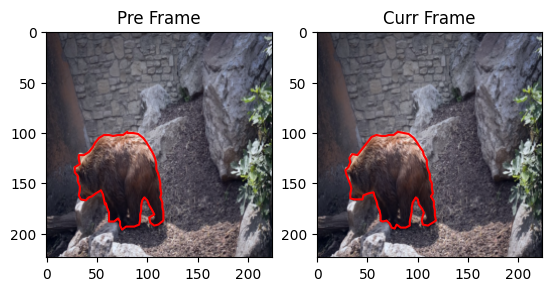

In [48]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [49]:
model = Model()

In [50]:
def chamer_distance_loss(x, y):
    def my_chamfer_distance(x, y):
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        dist = torch.sum((x - y) ** 2, dim=-1)
        dist1 = torch.min(dist, dim=1)[0]
        dist2 = torch.min(dist, dim=0)[0]
        return torch.mean(dist1) + torch.mean(dist2)
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

In [51]:
pre_boundary.shape, curr_boundary.shape

(torch.Size([10, 80, 2]), torch.Size([10, 80, 2]))

In [52]:
def order_loss(x: torch.Tensor, y: torch.Tensor):
    def my_order_loss(x, y):
        min_loss = (x - y).abs().sum()
        for shift in range(1, x.shape[0]):
            loss = (x - torch.roll(y, shifts=shift, dims=0)).abs().sum()
            min_loss = torch.min(min_loss, loss)
        return min_loss
        

    my_order_loss(x[0], y[0])
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_order_loss(x[i], y[i])

    return result / x.shape[0]
order_loss(pre_boundary, curr_boundary)

tensor(242.5000)

In [53]:
torch.cuda.empty_cache()

In [54]:
output = model(pre_frame, curr_frame, pre_boundary)
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(7.2013, grad_fn=<DivBackward0>)

In [62]:
model = Model().to('cuda')
# model_name = "uniform_model"
model_name = "simplify_model"
if model_name == "uniform_model":
    data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
else:
    data_set = DAVIS_Seq2(is_uniform=False, is_one_video=True)

loss_name = "chamer_distance_loss"
# loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 17
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [63]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

1.189138412475586

In [64]:
dict_loss = {}
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-5)
gradient_clip = 1
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
for e in range(num_epochs):
    model.train()
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = loss_func(predic_boundary, curr_boundary.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
    dict_loss[e] = loss.item()
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {loss.item()}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.80s/it]


Epoch 1, Loss: 9.51917552947998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.82s/it]


Epoch 2, Loss: 9.121371269226074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.47s/it]


Epoch 3, Loss: 8.860025405883789


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.09s/it]


Epoch 4, Loss: 8.893465995788574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.08s/it]


Epoch 5, Loss: 11.43353271484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.10s/it]


Epoch 6, Loss: 9.164040565490723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.82s/it]


Epoch 7, Loss: 8.299400329589844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.11s/it]


Epoch 8, Loss: 10.285785675048828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.11s/it]


Epoch 9, Loss: 8.95063304901123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.10s/it]


Epoch 10, Loss: 8.327906608581543


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]


Epoch 11, Loss: 10.339149475097656


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.90s/it]


Epoch 12, Loss: 9.165485382080078


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 13, Loss: 10.046685218811035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 14, Loss: 8.49706745147705


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 15, Loss: 9.008780479431152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]


Epoch 16, Loss: 9.422515869140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


Epoch 17, Loss: 8.894909858703613


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


Epoch 18, Loss: 9.462985038757324


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.08s/it]


Epoch 19, Loss: 10.72026252746582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


Epoch 20, Loss: 8.55131721496582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 21, Loss: 9.66416072845459


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 22, Loss: 9.238814353942871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 23, Loss: 8.798670768737793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 24, Loss: 11.478476524353027


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 25, Loss: 10.083047866821289


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 26, Loss: 9.121955871582031


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 27, Loss: 9.24840259552002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 28, Loss: 8.349649429321289


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 29, Loss: 9.152957916259766


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 30, Loss: 9.730557441711426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


Epoch 31, Loss: 9.433178901672363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


Epoch 32, Loss: 9.91797161102295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 33, Loss: 9.302029609680176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 34, Loss: 9.06360149383545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]


Epoch 35, Loss: 10.343219757080078


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 36, Loss: 9.004348754882812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]


Epoch 37, Loss: 10.982383728027344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


Epoch 38, Loss: 9.114944458007812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


Epoch 39, Loss: 11.161904335021973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.28s/it]


Epoch 40, Loss: 9.868362426757812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 41, Loss: 9.392173767089844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 42, Loss: 10.884746551513672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 43, Loss: 10.962369918823242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 44, Loss: 10.112797737121582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


Epoch 45, Loss: 9.376701354980469


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 46, Loss: 11.80422592163086


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


Epoch 47, Loss: 8.589353561401367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.17s/it]


Epoch 48, Loss: 8.683579444885254


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.75s/it]


Epoch 49, Loss: 10.681955337524414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]

Epoch 50, Loss: 9.149842262268066


In [65]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

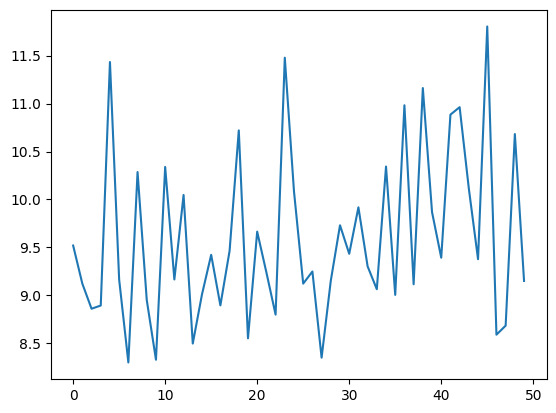

In [66]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [21]:
model = Model()
model_name = "uniform_model"
loss_name = "order_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

In [67]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:03<00:00, 26.48it/s]


0.3975609968534543

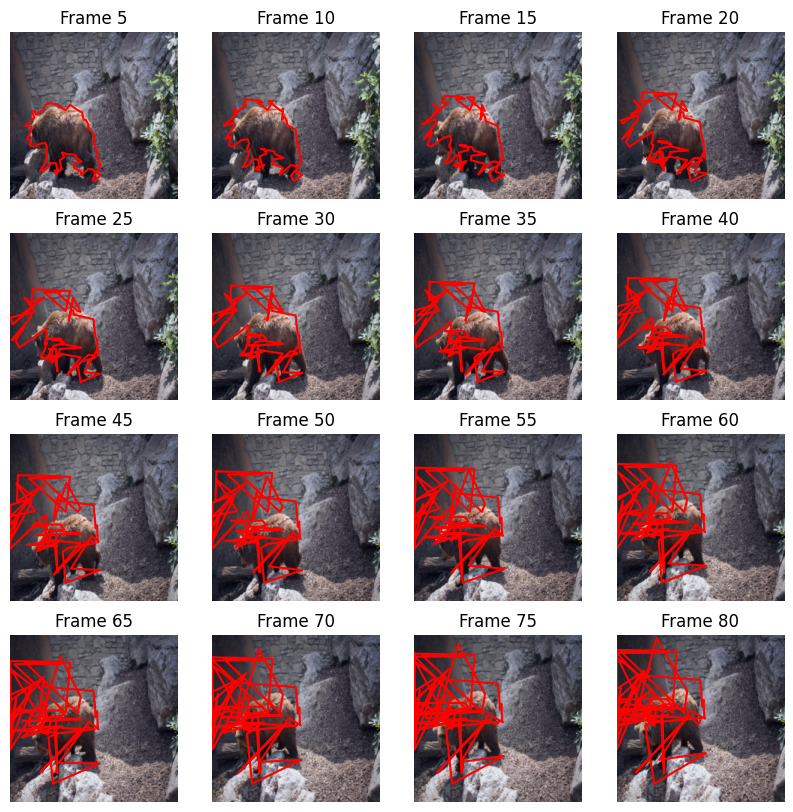

In [76]:
def test_model_one_video(model, test_dataset: DAVIS_test, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 5
    plt.figure(figsize=(10, 10))
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            pre_img = img
            if i % interval == 0:
                plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
test_model_one_video(model, DAVIS_test("bear", is_uniform=True))